<img src="./Logo_UNSAM.png" align="right" width="150" />

#### Procesamiento Digital de Señales
# TP final

## Detección de fallas mecánicas en maquinaria industrial mediante análisis de señales acústicas (MIMII Dataset)


#### Lucas Marú


# Introducción

En entornos industriales, el mantenimiento predictivo cumple un rol fundamental para evitar fallas inesperadas, reducir costos de reparación y optimizar la disponibilidad de los equipos. Entre las estrategias disponibles, el análisis de señales acústicas ha demostrado ser una herramienta efectiva para anticipar fallos a partir de cambios en el sonido emitido por las máquinas durante su funcionamiento.

El problema que se aborda en este trabajo es la detección de fallas en maquinaria a partir del sonido. Específicamente, se busca observar diferencias entre el comportamiento acústico de una máquina funcionando correctamente y la misma máquina operando en condiciones anómalas. Esta aproximación es especialmente relevante cuando no se dispone de sensores internos o cuando se desea realizar un monitoreo no invasivo.

Para llevar adelante este análisis se utilizará el MIMII Dataset (Malfunctioning Industrial Machine Investigation and Inspection), una base de datos pública que contiene grabaciones de audio de cuatro tipos de máquinas industriales: ventiladores, bombas, válvulas y rieles deslizantes. Las grabaciones incluyen condiciones normales y con fallas simuladas, y están disponibles en formato .wav, multicanal (8 micrófonos) y en distintos niveles de ruido ambiental para simular entornos realistas.

A pesar de que el MIMII Dataset fue diseñado principalmente para ser utilizado en el desarrollo y entrenamiento de modelos de detección de anomalías basados en aprendizaje profundo, en este trabajo se propone un enfoque distinto, más artesanal y centrado en la exploración. La idea es aplicar herramientas de procesamiento de señales estudiadas durante la cursada —como la transformada de Fourier, la estimación espectral con Welch y el análisis de energía— para identificar patrones o diferencias entre señales normales y anómalas. Esta decisión metodológica responde tanto al interés por comprender el comportamiento acústico de las máquinas como al alcance técnico de la materia.



# Objetivos

### Objetivo general  
Analizar señales acústicas de una máquina industrial (ventilador) mediante herramientas clásicas de procesamiento de señales, con el fin de detectar posibles diferencias entre condiciones normales y defectuosas, sin recurrir a modelos de aprendizaje automático.

### Objetivos específicos
- Visualizar y comparar señales individuales en el dominio temporal y frecuencial.
- Estimar el contenido espectral mediante FFT y Welch.
- Calcular métricas como energía por banda y detectar picos espectrales.
- Construir un perfil espectral típico de señales normales y compararlo contra señales anómalas.


# Descripción del dataset

Se trabajará con un subconjunto del **MIMII Dataset**, una base de datos pública que contiene grabaciones de audio de cuatro tipos de máquinas industriales: ventiladores, bombas, válvulas y rieles deslizantes. Cada tipo incluye siete máquinas individuales (`id_00`, `id_02`, etc.), registradas tanto en condiciones normales como con fallas simuladas, y en diferentes niveles de ruido ambiental (6 dB, 0 dB, -6 dB).

Las señales están almacenadas en archivos `.wav` de 10 segundos, grabados en simultáneo con 8 micrófonos a una frecuencia de muestreo de 16 kHz. Para mantener el análisis acotado y manejable, en esta etapa se trabajará exclusivamente con uno de los modelos disponibles: `fan_id_00`. Se analizarán tanto señales mono canal (utilizando un solo micrófono) como señales promediadas entre canales, con el objetivo de evaluar si el comportamiento acústico característico se mantiene o se refuerza según la forma de representación.

### Observaciones técnicas

Las señales anómalas fueron registradas tras introducir fallas reales (como desbalanceo o contaminación) en condiciones controladas, aunque el tipo de falla no se encuentra especificado. Esto refuerza el enfoque general del dataset, orientado a la detección de desviaciones respecto al comportamiento normal.

Las versiones con diferentes SNR fueron generadas mezclando las señales originales con ruido ambiental real, escalado para alcanzar una relación señal/ruido predeterminada. El contenido de la señal de máquina se mantiene constante entre versiones, lo que permite estudiar la influencia del ruido de forma aislada.

En este trabajo se hace foco exclusivamente en el modelo fan_id_00, correspondiente a un ventilador. Este modelo cuenta con una cantidad considerable de segmentos en condiciones normales y anómalas, lo cual garantiza una base suficiente para realizar un análisis comparativo robusto. El resto de los modelos del dataset presentan una distribución similar de muestras, lo que permitiría generalizar el enfoque a futuras extensiones del estudio.

# Análisis exploratorio de señales

A continuación se presenta un análisis exploratorio comparativo entre una señal en condición normal y una señal anómala del modelo `fan_id_00`. El objetivo es identificar visualmente y cuantitativamente diferencias que puedan estar asociadas al funcionamiento defectuoso.

### 1. Análisis en el dominio temporal

Se comienza con una inspección visual directa de la forma de onda. En la figura siguiente se muestra un fragmento de ambas señales para el canal 0 y de ambas señales con el promedio de los 8 canales:
<p align="center">
  <img src="SeñalTiempo_500ms.png" width="95%">
</p>

<p align="center"><small><em>Figura 2 – Señales temporales (500 ms) del canal 0 en condiciones normal y anómala.</em></small></p>


![Senal temporal](1.png)
<small><em>Figura 3 – Señales temporales (500 ms, multi-canal)</em></small>
<br><br>
En las señales promediadas multicanal no se observan oscilaciones dominantes de baja frecuencia que puedan interpretarse como desplazamientos de línea de base. Por el contrario, ambas señales se mantienen visualmente centradas alrededor de cero, lo que indica estabilidad general en ese sentido. También se aprecian múltiples oscilaciones de menor amplitud, posiblemente asociadas a ruido de alta frecuencia.

Para no sobrecargar el informe, se omite la presentación individual de cada uno de los ocho canales. No obstante, durante su inspección no se detectaron diferencias significativas entre ellos que justificaran un análisis separado. Por ello, el uso del promedio multicanal se considera adecuado como una estrategia para sintetizar el comportamiento global de la señal en distintos puntos del espacio acústico donde fueron adquiridas las mediciones.

Se observa que la señal anómala presenta, en promedio, mayor amplitud que la señal normal. Esta diferencia no se debe al agregado de ruido, ya que el SNR se controla de forma separada para cada grabación. Debido a esto, se interpreta como un efecto real del comportamiento mecánico defectuoso: las fallas introducidas (como desbalanceo o contacto anómalo) pueden provocar vibraciones más intensas o inestables, lo cual se traduce en mayor energía acústica captada por los micrófonos. Esta diferencia podría resultar útil como un primer indicador de una posible anomalía.


### 2. Análisis en el dominio espectral

Inspección de la distribución en frecuenca de ambas señales, se utilizó el método de Welch con ventana "hann" y 2048 muestras por segmento.
<br><br>
![Welch](WelchPropuesta.png)
<small><em>Figura 4 – Distribución en frecuencia (Welch)</em></small>
<br><br>
En el análisis visual podemos observar que ambas señales presentan energía distribuida a lo largo de un amplio rango de frecuencias, lo cual es consistente con el entorno industrial en el que fueron grabadas, donde el ruido de fondo tiene un carácter de banda ancha.

Sin embargo, se identificaron diferencias significativas en la distribución espectral entre ambas condiciones. En particular, se observó que a partir de aproximadamente 5 kHz la señal anómala presenta mayor energía que la señal normal. Esta diferencia no responde a un pico puntual, sino a una elevación generalizada del nivel espectral, lo que sugiere la presencia de ruido estructurado o vibraciones de alta frecuencia asociadas al mal funcionamiento de la máquina y es consistente respecto del ruido observado en la señal temporal.

En las frecuencias más bajas (por debajo de 1 kHz), ambas señales comparten una estructura espectral similar, con presencia de picos definidos. Estos podrían estar relacionados con el comportamiento mecánico normal del ventilador, como su frecuencia de rotación o modos resonantes.

Para poder realizar un análisis más pormenorizado de esta región del espectro, se estimó nuevamente el espectro mediante el método de Welch, pero aumentando la cantidad de muestras por ventana (`nperseg`) a 8192. Este ajuste permite mejorar la resolución en frecuencia, lo que facilita la identificación precisa de componentes espectrales estrechas, como oscilaciones mecánicas dominantes. Si bien este cambio implica una menor cantidad de ventanas y, por lo tanto, un mayor nivel de variabilidad en la estimación (mayor varianza), en este caso se priorizó la precisión espectral sobre la suavidad, dado el interés específico en la ubicación exacta de ciertos picos de energía.
<br><br>
![Welch_5k](Welch_flechas.png)
<small><em>Figura 5 – Distribución en frecuencia (Welch con 8192 muestras y hasta 5KHz)</em></small>
<br><br>
Con esta nueva estimación espectral tenemos una resolución del orden: $\Delta f = \frac{f_s}{\text{nperseg}} = \frac{16000}{8192} \approx 1.95\ \text{Hz}$ más acorde para ubicar con precisión los picos detectados en la señal anomala.

A grandes rasgos, el análisis espectral en el rango de 0 a 2000 Hz muestra tres comportamientos diferenciados:

1. **Picos coincidentes entre señales**:  
   Existen componentes espectrales que aparecen tanto en la señal normal como en la anómala con frecuencias prácticamente idénticas. Estos picos se interpretan como parte del comportamiento normal del sistema, probablemente asociados a la rotación del ventilador o a modos estructurales del conjunto mecánico.
   Un ejemplo claro es el pico alrededor de **60 Hz**, que coincide con una frecuencia de rotación de **3600 RPM**, típica en motores eléctricos trifásicos alimentados a red. También se observa su primer armónico en torno a **132 Hz**, presente en ambas señales. La estabilidad de estos componentes en ambas condiciones sugiere que no están directamente relacionados con la falla, sino que forman parte del funcionamiento esperado del sistema.

2. **Picos desplazados**:  
   También se observan picos en la señal anómala que parecen corresponder a versiones levemente desplazadas en frecuencia de picos presentes en la señal normal. Este corrimiento puede deberse a modificaciones en la rigidez, masa o condiciones de operación provocadas por la falla, que alteran las frecuencias naturales del sistema.

3. **Componentes exclusivas de la señal anómala**:  
   Finalmente, se identifican componentes espectrales que aparecen únicamente en la señal anómala. Estas frecuencias no están presentes en la señal normal, lo que sugiere que son generadas directamente por el funcionamiento defectuoso del equipo. Por tanto, pueden considerarse como indicadores acústicos específicos del estado de falla.


# Metodología

Con el fin de profundizar el análisis y cuantificar posibles diferencias entre señales normales y defectuosas, se propone aplicar un **filtro FIR pasabanda** que aísle una franja de alta frecuencia seleccionada en base a la inspección espectral previa.

Una vez filtrada cada señal, se calculará como estimador la **energía total contenida en esa banda**, con el objetivo de evaluar si dicho valor permite distinguir entre condiciones normales y anómalas.

A continuación se presenta el diseño e implementación del filtro.


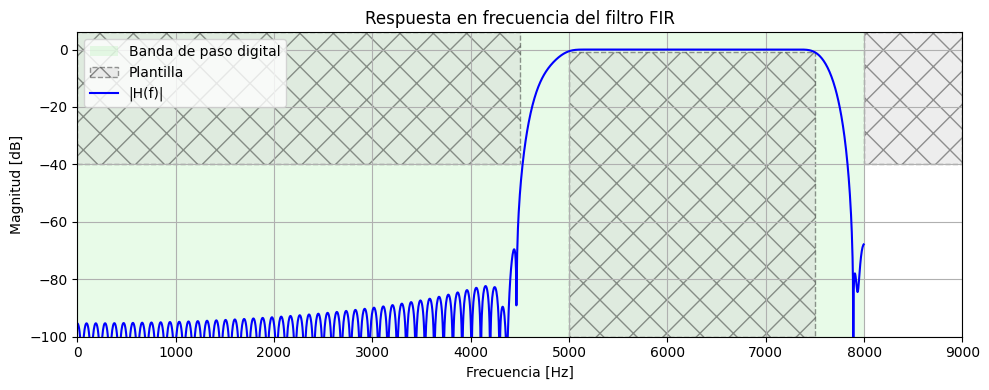

In [2]:
import numpy as np
from scipy import signal as sig
import matplotlib.pyplot as plt
from pytc2.sistemas_lineales import plot_plantilla

#%% PLANTILLA DE DISEÑO
# Frecuencia de muestreo
fs = 16000  # Hz
nyq = fs / 2  # Frecuencia de Nyquist

# Banda pasante deseada 
f_pass=(5000, 7500)

# Banda de atenuación
f_stop=(4500, 8000)

# Ripple permitido en la banda pasante
ripple_db = 1  # dB

# Atenuación mínima en la banda de stop
atten_db = 40  # dB

#%% DISEÑO DEL FILTRO FIR
# Frecuencias (en Hz)
freq = [0, 2250,4600,5000, 7500 , 7750, 8000]
gain = [0,  0  ,  0 , 1  ,   1  ,  0   , 0]

# Orden del filtro
numtaps = 171

# Diseño FIR con firwin2
b_fir = sig.firwin2(numtaps, freq, gain, fs=fs)

#%% RESPUESTA EN FRECUENCIA DEL FILTRO
w, h = sig.freqz(b_fir, worN=2048, fs=fs)

# Proteger contra log(0)
H_dB = 20 * np.log10(np.maximum(np.abs(h), 1e-12))

# Graficar
plt.figure(figsize=(10, 4))
plt.axis([0, fs / 2 +1000, -atten_db - 60, ripple_db + 5])
plot_plantilla(filter_type='bandpass',fpass=f_pass,ripple=ripple_db,
    fstop=f_stop,attenuation=atten_db,fs=fs)
plt.plot(w, H_dB, color='blue', label='|H(f)|')
plt.title("Respuesta en frecuencia del filtro FIR")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Magnitud [dB]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Luego del diseño del filtro FIR pasabanda, se aplicó dicho filtro a las señales normales y anómalas utilizando la función lfilter, la cual implementa un filtrado causal en el dominio temporal.

En particular, se filtraron las señales de los 8 micrófonos de forma independiente, así como también una novena señal obtenida como promedio de los 8 canales, con el objetivo de integrar la información multicanal en un solo canal representativo.

Para cada señal filtrada se calculó la energía total como la suma de los cuadrados de sus muestras. De esta forma se cuantificó la presencia de contenido energético dentro de la banda de interés.

Finalmente, se normalizaron los valores de energía respecto del máximo global observado (entre todas las señales normales y anómalas) con el fin de facilitar la comparación relativa entre ambos estados.

# Resultados y discusión

La Figura 6 muestra la comparación entre las energías normalizadas de las señales normales y anómalas, calculadas sobre la banda filtrada.
A continuación se presenta la comparación de la energía filtrada en la banda de 5–7.5 kHz para cada canal y el promedio multicanal.

<br><br>
![Energía por canal](energia_filtrada.png)  
<small><em>Figura 6 – Energía normalizada por canal (incluyendo promedio multicanal) respecto al valor máximo global</em></small>

Se observa que la energía asociada al promedio multicanal es significativamente menor que la de los canales individuales, al punto de casi no visualizarse en el gráfico. Esta diferencia podría deberse a que, al promediar las señales de los distintos micrófonos, algunas variaciones pequeñas entre ellas —como diferencias en el tiempo de llegada o en la forma exacta de la señal— se cancelan entre sí. Esto podría resaltar en bandas donde ya hay poca energía, como la analizada, lo que hace que el resultado final del promedio sea aún más bajo.

Sería interesante, como análisis futuro, verificar si esta disminución de energía en el promedio se repite en otras máquinas del dataset o bajo distintas condiciones. Esto permitiría evaluar si se trata de un efecto generalizable —propio de cómo se comportan las señales al promediarse en bandas altas— o si responde a características particulares del experimento, como la disposición de los micrófonos o la naturaleza específica del sonido en esta máquina.
<br><br>
![Welch promedio](welch_promedio.png)  
<small><em>Figura 7 – Densidad espectral de potencia (Welch) para las señales promedio normal y anómala</em></small>

La Figura 7 muestra el espectro estimado por Welch para las señales promedio multicanal. Se incluye aquí con el objetivo de corroborar visualmente que el contenido energético en la banda de interés (alrededor de 5–7.5 kHz) es, al menos, un orden de magnitud menor que el observado en los canales individuales (Figura 4).
Esta diferencia justifica el valor mucho más bajo que toma la energía del promedio en el histograma global (Figura 6), incluso a pesar de que se conserva una diferencia clara entre las señales normales y anómalas.

Para observar esta diferencia con mayor claridad, se presenta a continuación la energía de las señales promedio, normalizadas respecto a su propio máximo.

<br><br>
![Energía promedio](energia_promedios.png)  
<small><em>Figura 8 – Energía normalizada para las señales promedio multicanal (normal vs anómala)</em></small>

### Conclusión

En conjunto, los resultados obtenidos muestran que la energía contenida en la banda filtrada de 5 a 7.5 kHz permite diferenciar de forma consistente entre señales normales y anómalas, tanto a nivel de canales individuales como en el promedio multicanal, tal como sugirió el análisis exploratorio.  
Si bien el contenido energético en el promedio resulta considerablemente menor, se mantiene la diferencia relativa entre ambos estados, lo que refuerza la utilidad de este enfoque como herramienta de detección.  
Además, dado que el método se basa únicamente en el filtrado y acumulación de energía —sin etapas de entrenamiento ni algoritmos complejos—, resulta especialmente adecuado para una implementación en tiempo real con bajo costo computacional, a diferencia de esquemas más pesados basados en aprendizaje profundo.
